<h1 align='center'><u><font color ='pickle'>Sentiment Analysis on IMDB dataset</u></h1></font>


# <font color ='pickle'>**Notebook Overview**
* Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and Feature Engineering.
* lets use all these techniques and create a classification pipeline for it.
* We will create 3 pipelines:
    1. Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model pipeline
    2. Feature Engineering + ML Model pipeline
    3. Feature Engineering + Data Preprocessing + Sparse Embeddings(TF-IDF) + ML Model pipeline.

# <font color ='pickle'>**Installing/Importing libraries**

In [1]:
# Import necessary libraries
import pandas as pd
from pathlib import Path

# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  !pip install -U nltk -qq
  !pip install -U spacy -qq
  !python -m spacy download en_core_web_sm -qq

  basepath  = '/content/drive/MyDrive/data'
  sys.path.append('/content/drive/MyDrive/data/custom-functions')
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'
  sys.path.append('/home/harpreet/Insync/google_drive_shaannoor/data/custom-functions')

Mounted at /content/drive
2023-09-14 16:32:40.762224: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 16:32:42.384147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 53.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/data/custom-functions']

In [15]:
base_folder = Path(basepath)
data_folder = base_folder/'datasets'
model_folder = base_folder/'models/nlp_spring_2023/imdb'
custom_functions = base_folder/'custom-functions'

In [16]:
model_folder.mkdir(exist_ok=True)

In [17]:
import custom_preprocessor_mod as cp
from  featurizer import ManualFeatures
from  plot_learning_curve import plot_learning_curve

# <font color ='pickle'>**Load dataset**

For this notebook, we will use IMDB movie review dataset. <br>
LInk for complete dataset: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz.

We downloaded the dataset in the previous lecture (notebook: Faster_tokenization_spacy_final.ipynb)

We will now use the saved train.csv and test.csv file.

In [18]:
# location of train and test files
train_file = data_folder / 'train.csv'
test_file = data_folder / 'test.csv'

In [19]:
# creating Pandas Dataframe
train_data = pd.read_csv(train_file, index_col=0)
test_data = pd.read_csv(test_file, index_col=0)

In [20]:
# print shape of the datasets
print(f'Shape of Training data set is : {train_data.shape}')
print(f'Shape of Test data set is : {test_data.shape}')

Shape of Training data set is : (25000, 2)
Shape of Test data set is : (25000, 2)


In [21]:
# Printing top 5 train records
train_data.head()

,Reviews,Labels
0,I think this movie would be more enjoyable if ...,1
1,"Timeless musical gem, with Gene Kelly in top f...",1
2,I just found the IMDb and searched this film a...,1
3,It's a short movie from David Lynch with just ...,1
4,I dug out from my garage some old musicals and...,1


In [22]:
# Printing top 5 test records
test_data.head()

,Reviews,Labels
0,I bought the DVD a long time ago and finally g...,1
1,It was sad that COMMITTED lasted only two week...,1
2,"If I look hard enough, flaws can be found in t...",1
3,This is the first feature film from Australian...,1
4,"Boogie Nights is full of surprises, nothing qu...",1


# <font color ='pickle'>**Create Subset of Data**

In [23]:
train_smaller = train_data.sample(frac=0.1, replace=True, random_state=1)

In [24]:
test_smaller = test_data.sample(frac=0.1, replace=True, random_state=1)

# <font color ='pickle'>**Exploratory Data Analysis**

In [25]:
# Printing basic info
train_smaller.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 235 to 21762
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Reviews  2500 non-null   object
 1   Labels   2500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 58.6+ KB


In [26]:
# Checking distribution of class labels for train dataset
train_smaller['Labels'].value_counts()

1    1286
0    1214
Name: Labels, dtype: int64

In [27]:
# Checking distribution of class labels for test dataset
test_smaller['Labels'].value_counts()

1    1286
0    1214
Name: Labels, dtype: int64

As we can see our data is well balannced.

# <font color ='pickle'>**Classification Pipeline**

## <font color ='pickle'>**PreProcessing**

In [28]:
X_train = train_smaller['Reviews'].values
X_test = test_smaller['Reviews'].values
y_train = train_smaller['Labels'].values
y_test = test_smaller['Labels'].values

print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (2500,) y_train: (2500,)
X_test: (2500,) y_test: (2500,)


In [29]:
cp.SpacyPreprocessor?

In [30]:
X_train_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(X_train)

/content/drive/MyDrive/data/custom-functions/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [31]:
# save this to a file
file_X_train_cleaned_sparse_embed = data_folder / 'x_train_cleaned_sparse_embed.pkl'

In [32]:
joblib.dump(X_train_cleaned, file_X_train_cleaned_sparse_embed)

['/content/drive/MyDrive/data/datasets/x_train_cleaned_sparse_embed.pkl']

In [33]:
X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(X_test)

In [34]:
# save  this to a file
file_X_test_cleaned_sparse_embed = data_folder / 'x_test_cleaned_sparse_embed.pkl'

In [35]:
joblib.dump(X_test_cleaned, file_X_test_cleaned_sparse_embed)

['/content/drive/MyDrive/data/datasets/x_test_cleaned_sparse_embed.pkl']

## <font color ='pickle'>**Pipeline 1: Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model**

### <font color ='pickle'>**Create Pipeline**

In [36]:
classifier_1 = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
    ('classifier', LogisticRegression(max_iter=10000)),
                        ])

### <font color ='pickle'>**Parameter Grid**

In [37]:
param_grid_classifier_1 = {'vectorizer__max_features': [100, 500, 1000, 2000, 5000],
                            'classifier__C': [0.1, 1, 10, 100, 100000]
                           }

### <font color ='pickle'>**Specify GridSearch**

In [38]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# The advantage of using pipelines is that we can avoid data leakage
# Since we have balanced data set, we will use default scoring method of accuracy
# the typical value of cv used is 5. We are using 3, just for demonstration.

grid_classifier_1 = GridSearchCV(estimator=classifier_1, param_grid=param_grid_classifier_1, cv = 3)

### <font color ='pickle'>**Fit the model**

In [39]:
# Fit the model on training data
X_train_cleaned_sparse_embed = joblib.load(file_X_train_cleaned_sparse_embed)
grid_classifier_1.fit(X_train_cleaned_sparse_embed, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer',
                                        TfidfVectorizer(token_pattern='[\\S]+')),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100, 100000],
                         'vectorizer__max_features': [100, 500, 1000, 2000,
                                                      5000]})

### <font color = 'pickle'>**Get Best Params**

In [40]:
print(f'Best cross-validation score: {grid_classifier_1.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_1.best_params_)
print("\nBest estimator: ", grid_classifier_1.best_estimator_)

Best cross-validation score: 0.86

Best parameters:  {'classifier__C': 10, 'vectorizer__max_features': 5000}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=5000, token_pattern='[\\S]+')),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])


### <font color ='pickle'>**Save Model**

In [41]:
file_best_estimator_pipeline1_round1 = model_folder / 'pipeline1_round1_best_estimator.pkl'
file_complete_grid_pipeline1_round1 = model_folder / 'pipeline1_round1_complete_grid.pkl'

In [42]:
joblib.dump(grid_classifier_1.best_estimator_, file_best_estimator_pipeline1_round1)
joblib.dump(grid_classifier_1, file_complete_grid_pipeline1_round1)

['/content/drive/MyDrive/data/models/nlp_spring_2023/imdb/pipeline1_round1_complete_grid.pkl']

### <font color ='pickle'>**Load Saved Model**

In [43]:
# load the saved model
best_estimator_pipeline1_round1 = joblib.load(file_best_estimator_pipeline1_round1)
complete_grid_pipeline1_round1 = joblib.load(file_complete_grid_pipeline1_round1)

### <font color ='pickle'>**Plot Learning Curve**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

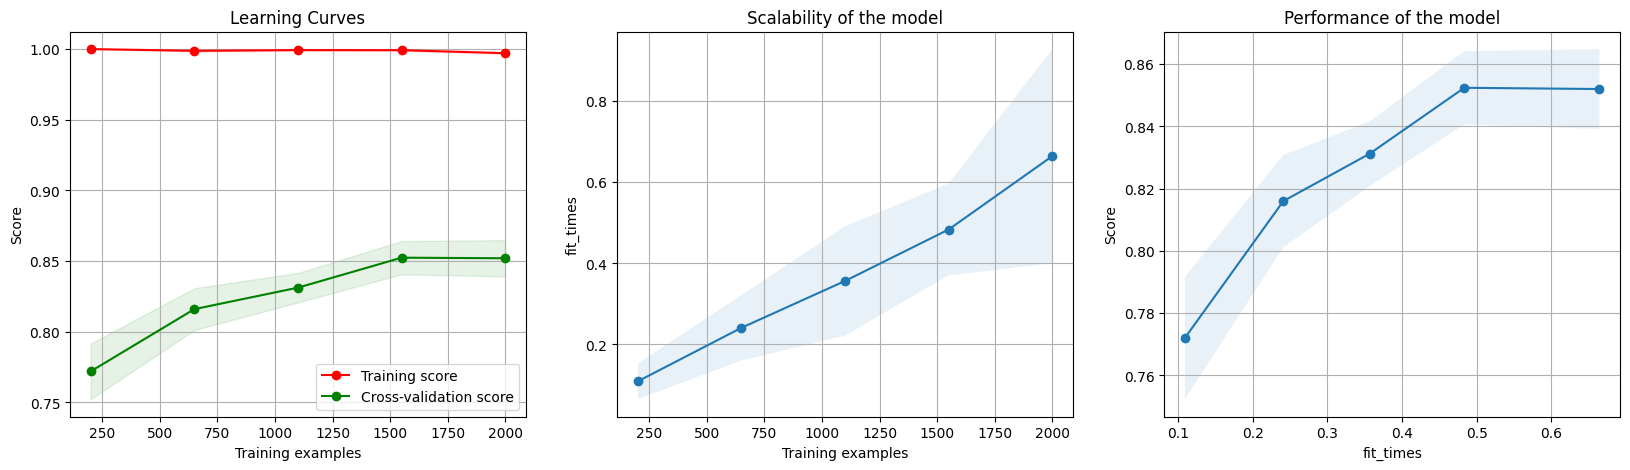

In [44]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline1_round1, 'Learning Curves',
                    X_train_cleaned_sparse_embed, y_train, n_jobs=-1)

<font color ='indianred'>**Observations**</font>
<br>
Clearly there is <font color ='indianred'>**overfitting**</font>. In case of overfitting we can improve results by

1. Adding more data (training model on complete dataset)
2. By hyperparameter tuning (reduce model complexity) of logistic regression and vectorizer.


### <font color = 'pickle'>**Check Cross Validation Score and Train Score**

In [45]:
# let's check the train scores
print(best_estimator_pipeline1_round1.score(X_train_cleaned_sparse_embed, y_train))

# let's check the cross validation score
print(complete_grid_pipeline1_round1.best_score_)

0.9964
0.8580031532996891


### <font color ='pickle'>**Evaluate model on test datset**

In [46]:
# Final Pipeline
def final_pipeline(text):
    # X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    cleaned_text = joblib.load(file_X_test_cleaned_sparse_embed)
    best_estimator_pipeline1_round1 = joblib.load(file_best_estimator_pipeline1_round1)
    predictions = best_estimator_pipeline1_round1.predict(cleaned_text)
    return predictions

In [47]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

### <font color ='pickle'>**Classification report for test dataset**

* As we have already seen, our dataset is well balanced. Hence we have used accuracy as our scoring method.
* However, it is a good idea to also look at classification report which gives precision, recall, and f1-score for both labels and average score also.

In [48]:
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.84      0.82      0.83      1214
           1       0.84      0.85      0.84      1286

    accuracy                           0.84      2500
   macro avg       0.84      0.84      0.84      2500
weighted avg       0.84      0.84      0.84      2500



## <font color ='pickle'>**Pipeline 2: Data Preprocessing + Manual Features + ML Model pipeline**

In this case we will extract following features and use these as the input to our logistic regression.
  1. number of words
  2. number of characters
  3. number of characters without space
  4. average word length
  5. number of digits
  6. number of numbers
  7. number of nouns or propernouns
  8. number of aux
  9. number of verbs
  10. number of adjectives
  11. number of ner (entiites)

### <font color ='pickle'>**Generate Manual Features**

In [49]:
ManualFeatures?

In [50]:
featurizer = ManualFeatures(spacy_model='en_core_web_sm')

In [51]:
X_train_features, feature_names = featurizer.fit_transform(X_train)

/content/drive/MyDrive/data/custom-functions/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [52]:
X_train_features[0:3]

array([[2.83000000e+02, 1.47100000e+03, 1.18900000e+03, 4.18661972e+00,
        5.00000000e+00, 3.00000000e+00, 1.70000000e+01, 6.70000000e+01,
        1.70000000e+01, 2.50000000e+01, 2.80000000e+01],
       [6.63000000e+02, 3.62100000e+03, 2.95900000e+03, 4.45632530e+00,
        0.00000000e+00, 0.00000000e+00, 3.60000000e+01, 1.64000000e+02,
        4.90000000e+01, 9.40000000e+01, 4.60000000e+01],
       [2.90000000e+02, 1.50400000e+03, 1.21500000e+03, 4.17525773e+00,
        2.00000000e+00, 2.00000000e+00, 1.10000000e+01, 5.40000000e+01,
        3.40000000e+01, 3.40000000e+01, 2.40000000e+01]])

In [53]:
feature_names

['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_digits',
 'count_numbers',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'ner']

### <font color ='pickle'>**Create Pipeline**

In [54]:
classifier_2 = Pipeline([
    ('classifier', LogisticRegression(max_iter=10000)),
                        ])

### <font color ='pickle'>**Parameter Grid**

In [55]:
# Ideally we can specify range of values for other parameters
# If the search space is very large then we should use RandomSerachCV
# or some other methods

param_grid_classifier_2 = {'classifier__C': [0.01, 10, 1000, 100000]}

### <font color ='pickle'>**Specify GridSearch**

In [56]:
# the typical value of cv used is 5. We are using 3, just for demonstration.

grid_classifier_2 = GridSearchCV(estimator=classifier_2,
                                 param_grid=param_grid_classifier_2,
                                 cv=3)

### <font color ='pickle'>**Fit the Model**

In [57]:
# Fit the model on training data
grid_classifier_2.fit(X_train_features, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.01, 10, 1000, 100000]})

### <font color ='pickle'>**Get Best Params**

In [58]:
print(f'Best cross-validation score: {grid_classifier_2.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_2.best_params_)
print("\nBest estimator: ", grid_classifier_2.best_estimator_)

Best cross-validation score: 0.60

Best parameters:  {'classifier__C': 100000}

Best estimator:  Pipeline(steps=[('classifier', LogisticRegression(C=100000, max_iter=10000))])


### <font color ='pickle'>**Save Model**

In [59]:
file_best_estimator_pipeline2_round1 = model_folder / 'pipeline2_round1_best_estimator.pkl'
file_complete_grid_pipeline2_round1 = model_folder / 'pipeline2_round1_complete_grid.pkl'

In [60]:
joblib.dump(grid_classifier_2.best_estimator_, file_best_estimator_pipeline2_round1)
joblib.dump(grid_classifier_2, file_complete_grid_pipeline2_round1)

['/content/drive/MyDrive/data/models/nlp_spring_2023/imdb/pipeline2_round1_complete_grid.pkl']

### <font color ='pickle'>**Load Saved Model**

In [61]:
# load the saved model
best_estimator_pipeline2_round1 = joblib.load(file_best_estimator_pipeline2_round1)
complete_grid_pipeline2_round1 = joblib.load(file_complete_grid_pipeline2_round1)

### <font color ='pickle'>**Plot Learning Curve**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

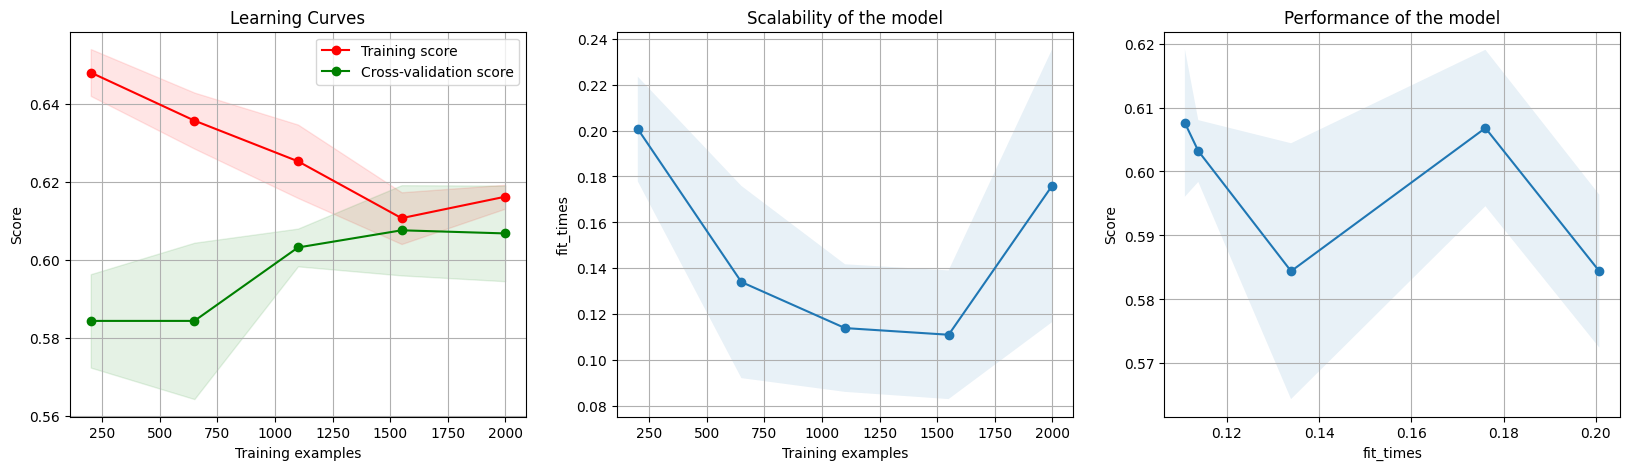

In [62]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline2_round1, 'Learning Curves',
                    X_train_features, y_train, n_jobs=-1)

<font color ='indianred'>**Observations** </font>
<br>
Clearly there is <font color ='indianred'> **underfitting** </font>. In case of underfitting we can improve results by

1. By hyperparameter tuning (increase model complexity) of logistic regression.
2. Add New features or Polynomial terms

### <font color = 'pickle'>**Check Cross Validation Score and Train Score**

In [63]:
# let's check the train scores
print(best_estimator_pipeline2_round1.score(X_train_features, y_train))

# let's check the cross validation score
print(complete_grid_pipeline2_round1.best_score_)

0.6184
0.6023963542251433


### <font color ='pickle'>**Evaluate model on test datset**

In [64]:
# Final Pipeline
def final_pipeline(text):
    features, feature_names = featurizer.fit_transform(text)
    best_estimator_pipeline2_round1 = joblib.load(file_best_estimator_pipeline2_round1)
    predictions = best_estimator_pipeline2_round1.predict(features)
    return predictions

In [65]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

/content/drive/MyDrive/data/custom-functions/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


### <font color ='pickle'>**Classification report for test dataset**

In [66]:
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.60      0.62      0.61      1214
           1       0.63      0.61      0.62      1286

    accuracy                           0.61      2500
   macro avg       0.61      0.61      0.61      2500
weighted avg       0.61      0.61      0.61      2500



## <font color ='pickle'>**Pipeline 3: Combine Manual Features and TfID vectors**

### <font  color ='pickle'>**Combine Manual Features and tfidf features**

<font size = 4, color ='indianred'>**The approach described in this section is generic and can be used to combine any text with non-text related variables**.

In [67]:
X_train_cleaned_sparse_embed = joblib.load(file_X_train_cleaned_sparse_embed)

In [68]:
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned_sparse_embed, columns=['cleaned_text']),
                           pd.DataFrame(X_train_features, columns=feature_names)), axis =1)

In [69]:
X_train_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner
0,typical cheerful colorful mgm musical early 50...,283.0,1471.0,1189.0,4.186620,5.0,3.0,17.0,67.0,17.0,25.0,28.0
1,paul f. ryan length feature manage amazing ens...,663.0,3621.0,2959.0,4.456325,0.0,0.0,36.0,164.0,49.0,94.0,46.0
2,think great viewer miss entirely fact obviousl...,290.0,1504.0,1215.0,4.175258,2.0,2.0,11.0,54.0,34.0,34.0,24.0
3,film bad believe actually shoot people vote 10...,181.0,929.0,749.0,4.115385,8.0,5.0,5.0,38.0,19.0,17.0,21.0
4,watch wonderful world disney abc night come co...,234.0,1231.0,998.0,4.246809,6.0,5.0,13.0,56.0,13.0,29.0,18.0


In [70]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cleaned_text               2500 non-null   object 
 1   count_words                2500 non-null   float64
 2   count_characters           2500 non-null   float64
 3   count_characters_no_space  2500 non-null   float64
 4   avg_word_length            2500 non-null   float64
 5   count_digits               2500 non-null   float64
 6   count_numbers              2500 non-null   float64
 7   noun_count                 2500 non-null   float64
 8   aux_count                  2500 non-null   float64
 9   verb_count                 2500 non-null   float64
 10  adj_count                  2500 non-null   float64
 11  ner                        2500 non-null   float64
dtypes: float64(11), object(1)
memory usage: 234.5+ KB


In [71]:
subset = X_train_final[0:10]

In [72]:
subset.shape

(10, 12)

In [73]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

In [74]:
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)), ])

In [75]:
sparse_features.fit_transform(subset.iloc[:, 1:])

<10x11 sparse matrix of type '<class 'numpy.float64'>'
	with 104 stored elements in Compressed Sparse Row format>

In [76]:
vectorizer.fit_transform(subset.iloc[:, 0])

<10x5 sparse matrix of type '<class 'numpy.float64'>'
	with 29 stored elements in Compressed Sparse Row format>

In [77]:
combined_features = ColumnTransformer(
 transformers=[
     ('tfidf', vectorizer, 'cleaned_text'),
      ], remainder=sparse_features
     )

In [78]:
test = combined_features.fit_transform(subset)

In [79]:
test.dtype

dtype('float64')

### <font color ='pickle'>**Create Final Pipeline**

In [80]:
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', LogisticRegression(max_iter=10000)),
                        ])

In [81]:
classifier_3.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'combined_features', 'classifier', 'combined_features__n_jobs', 'combined_features__remainder__memory', 'combined_features__remainder__steps', 'combined_features__remainder__verbose', 'combined_features__remainder__sparse', 'combined_features__remainder', 'combined_features__sparse_threshold', 'combined_features__transformer_weights', 'combined_features__transformers', 'combined_features__verbose', 'combined_features__verbose_feature_names_out', 'combined_features__tfidf', 'combined_features__tfidf__memory', 'combined_features__tfidf__steps', 'combined_features__tfidf__verbose', 'combined_features__tfidf__tfidf', 'combined_features__tfidf__tfidf__analyzer', 'combined_features__tfidf__tfidf__binary', 'combined_features__tfidf__tfidf__decode_error', 'combined_features__tfidf__tfidf__dtype', 'combined_features__tfidf__tfidf__encoding', 'combined_features__tfidf__tfidf__input', 'combined_features__tfidf__tfidf__lowercase', 'combined_features__tfidf_

### <font color ='pickle'>**Parameter Grid**

In [82]:
# We are exploring a small combination of parameters
# If the search space is very large then we should use RandomSerachCV or some other methods

param_grid_classifier_3 = {'combined_features__tfidf__tfidf__max_features': [500, 1000, 2000],
                           'classifier__C': [0.1, 1, 10]
                          }

### <font color ='pickle'>**Specify GridSearch**

In [83]:
# We will now use Gridserach to find fine tune hyperparameters using cross validation
# the typical value of cv used is 5. We are using 3, just for demonstration.

grid_classifier_3 = GridSearchCV(estimator=classifier_3,
                                 param_grid=param_grid_classifier_3,
                                 cv=3)

### <font color ='pickle'>**Fit the Model**

In [84]:
# Fit the model on training data
grid_classifier_3.fit(X_train_final, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('combined_features',
                                        ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                     SparseTransformer())]),
                                                          transformers=[('tfidf',
                                                                         Pipeline(steps=[('tfidf',
                                                                                          TfidfVectorizer(max_features=5))]),
                                                                         'cleaned_text')])),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'combined_features__tfidf__tfidf__max_features': [500,
                                                                           1000,
                                                                           2000]})

### <font color ='pickle'>**Get Best Params**

In [85]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_3.best_score_))
print("\nBest parameters: ", grid_classifier_3.best_params_)
print("\nBest estimator: ", grid_classifier_3.best_estimator_)

Best cross-validation score: 0.84

Best parameters:  {'classifier__C': 10, 'combined_features__tfidf__tfidf__max_features': 2000}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=2000))]),
                                                  'cleaned_text')])),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])


### <font color ='pickle'>**Save Model**

In [86]:
file_best_estimator_pipeline3_round1 = model_folder / 'pipeline3_round1_best_estimator.pkl'
file_complete_grid_pipeline3_round1 = model_folder / 'pipeline3_round1_complete_grid.pkl'

In [87]:
joblib.dump(grid_classifier_3.best_estimator_, file_best_estimator_pipeline3_round1)
joblib.dump(grid_classifier_3, file_complete_grid_pipeline3_round1)

['/content/drive/MyDrive/data/models/nlp_spring_2023/imdb/pipeline3_round1_complete_grid.pkl']

### <font color ='pickle'>**Load Saved Model**

In [88]:
# load the saved model
best_estimator_pipeline3_round1 = joblib.load(file_best_estimator_pipeline3_round1)
complete_grid_pipeline3_round1 = joblib.load(file_complete_grid_pipeline3_round1)

### <font color ='pickle'>**Plot Learning Curve**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

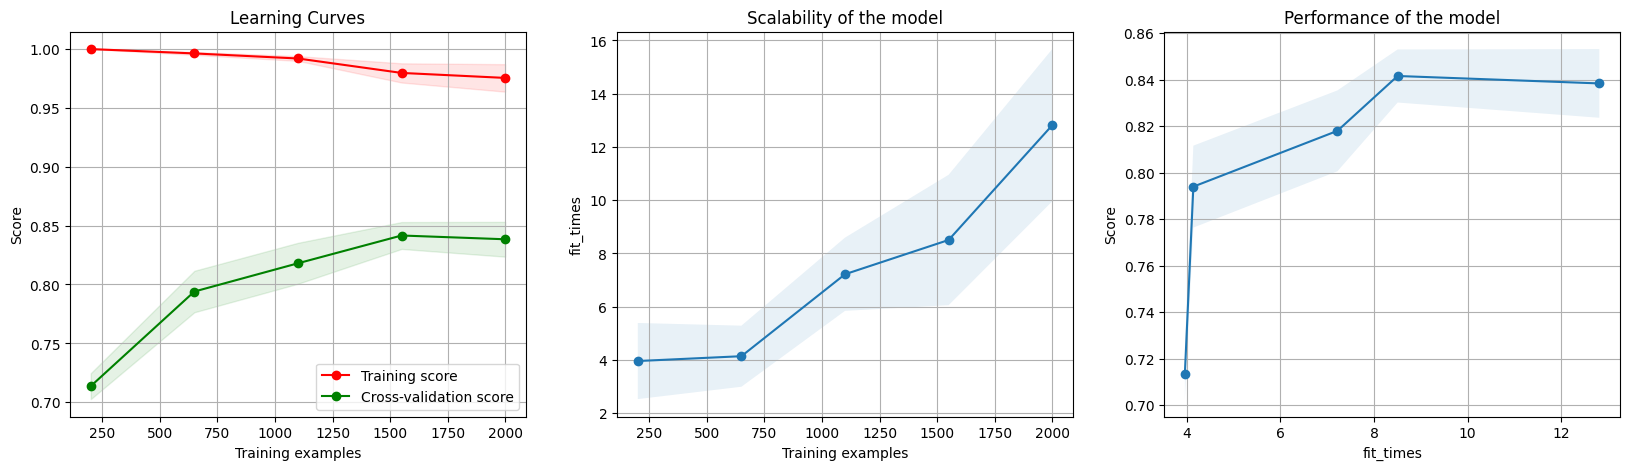

In [89]:
# plot learning curces
plot_learning_curve(best_estimator_pipeline3_round1, 'Learning Curves',
                    X_train_final, y_train, n_jobs=-1)

<font color ='indianred'>**Observations**
<br></font>
Clearly there is <font color ='indianred'>**overfitting**</font>. In case of overfitting we can improve results by

1. Adding more data (training model on complete dataset)
2. By hyperparameter tuning (reduce model complexity) of logistic regression and vectorizer.

### <font color = 'pickle'>**Check Cross Validation Score and Train Score**

In [90]:
# let's check the train scores
print(best_estimator_pipeline3_round1.score(X_train_final, y_train))

# let's check the cross validation score
print(complete_grid_pipeline3_round1.best_score_)

0.9752
0.8432025088212743


### <font color ='pickle'>**Evaluate model on test datset**

In [91]:
X_test.shape

(2500,)

In [92]:
# Final Pipeline
def final_pipeline(text):
    # X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    cleaned_text = joblib.load(file_X_test_cleaned_sparse_embed)
    X_features, feature_names = featurizer.fit_transform(text)
    X_final = pd.concat((pd.DataFrame(cleaned_text, columns=['cleaned_text']),
                         pd.DataFrame(X_features, columns=feature_names)), axis=1)
    best_estimator_pipeline3_round1 = joblib.load(file_best_estimator_pipeline3_round1)
    predictions = best_estimator_pipeline3_round1.predict(X_final)
    return predictions

In [93]:
# predicted values for Test data set
y_test_pred = final_pipeline(X_test)

/content/drive/MyDrive/data/custom-functions/custom_preprocessor_mod.py:90: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


### <font color ='pickle'>**Classification report for test dataset**

In [94]:
print('\nTest set classification report:\n\n', classification_report(y_test, y_test_pred ))


Test set classification report:

               precision    recall  f1-score   support

           0       0.83      0.81      0.82      1214
           1       0.82      0.85      0.84      1286

    accuracy                           0.83      2500
   macro avg       0.83      0.83      0.83      2500
weighted avg       0.83      0.83      0.83      2500

